In [1]:
import tensorflow as tf
import numpy as np
tf.random.set_seed(100)

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Activation, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import  EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD
from keras.utils.vis_utils import plot_model
from keras.models import load_model
from keras.utils import to_categorical
from tensorflow.keras.layers import Dropout
from keras import backend as K 
from tensorflow.keras.utils import Sequence

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import cv2
import random
import os
import glob

import urllib
import tarfile
from zipfile import ZipFile
import scipy.io
from PIL import Image, ImageDraw, ImageEnhance

import imgaug as ia
ia.seed(1)

%matplotlib inline
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
from imgaug import augmenters as iaa 


import imageio
import pandas as pd
import numpy as np
import re

import shutil

# 4. Cargue todas las fotos en Jupyter

In [2]:
#images = [cv2.imread(file) for file in glob.glob("Figs/*.jpg")]
#images = images.astype('float32')
#images = images / 255.0

In [3]:
labels = ['perros', 'gatos']
img_size = 224
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return data#np.array(data, dtype=object)

In [4]:
imgs = get_data(r'C:\Users\FRARIV\Desktop\DSC\Descenso del gradiente\Figs')

<AxesSubplot:ylabel='count'>

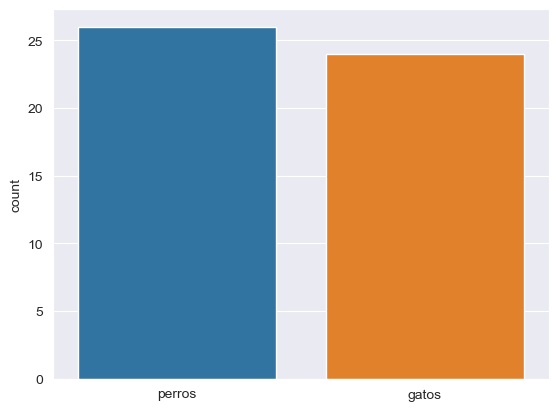

In [5]:
import seaborn as sns
l = []
#l = np.array(l, dtype=object)
for i in range(len(imgs)):
    if(imgs[i][1] == 0):
        l.append('perros')
    else:
        l.append('gatos')
sns.set_style('darkgrid')
sns.countplot(x=l)

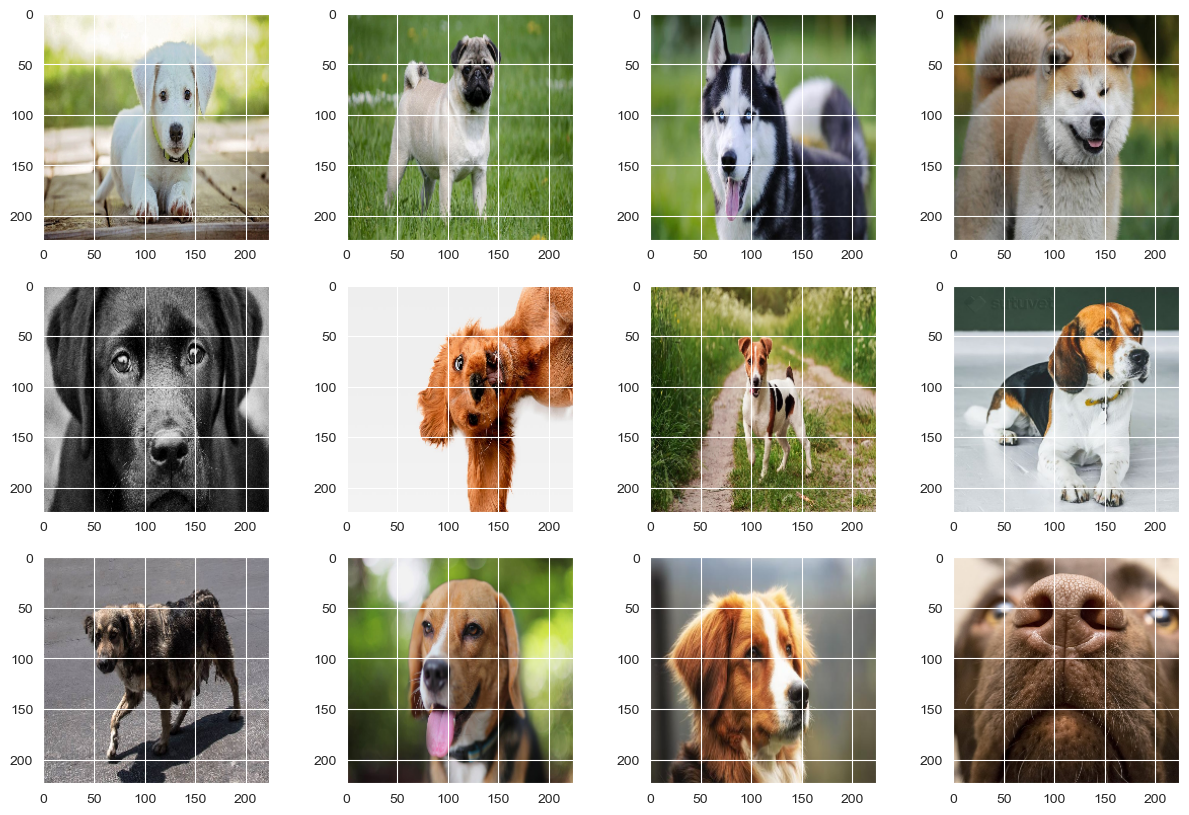

In [6]:
# plot first few images
plt.figure(figsize=(15, 10))
for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow((imgs[i][0]))

# 5. Cargue el CSV en Jupyter

In [7]:
df = pd.read_csv('labels_perros_gatos_2022-12-12-09-32-41.csv')
df.head()

label_name  bbox_x  bbox_y  bbox_width  bbox_height  \
0       gato     319       7         892          892   
1       gato      44     219         834          291   
2       gato     138      29         352          389   
3      perro     275      90         731          598   
4      perro     166      56         513          460   

                                    image_name  image_width  image_height  
0  01-cat-names-nationalgeographic_1525054.jpg         1600           900  
1                            1586819005651.jpg          976           651  
2                           16164882584432.jpg          640           426  
3                           16456899624763.jpg         1320           743  
4                           16530529447979.jpg          990           558

In [8]:
df['bbox_xmax'] = df['bbox_x'] + df['bbox_width']
df['bbox_ymax'] = df['bbox_y'] + df['bbox_height']
df['label_name'] = df['label_name'] + 's'
df['filename'] = df['label_name'] + os.sep + df['image_name']
df.head()

label_name  bbox_x  bbox_y  bbox_width  bbox_height  \
0      gatos     319       7         892          892   
1      gatos      44     219         834          291   
2      gatos     138      29         352          389   
3     perros     275      90         731          598   
4     perros     166      56         513          460   

                                    image_name  image_width  image_height  \
0  01-cat-names-nationalgeographic_1525054.jpg         1600           900   
1                            1586819005651.jpg          976           651   
2                           16164882584432.jpg          640           426   
3                           16456899624763.jpg         1320           743   
4                           16530529447979.jpg          990           558   

   bbox_xmax  bbox_ymax                                           filename  
0       1211        899  gatos\01-cat-names-nationalgeographic_1525054.jpg  
1        878        510                            gatos\1586819005651.jpg  
2        490        418                           gatos\16164882584432.jpg  
3       1006        688                          perros\16456899624763.jpg  
4        679        516                          perros\16530529447979.jpg

# 6. Aumente las imágenes para que tenga al menos 100 imágenes de gatos y 100 de perros

In [9]:
# Función para convertir la imagen del cuadro delimitador en DataFrame
def bounding_boxes_to_df(bounding_boxes_object):

    # Convertir objeto de cuadros delimitadores en matriz
    bounding_boxes_array = bounding_boxes_object.to_xyxy_array()
    
    # Convierte la matriz en DataFrame
    df_bounding_boxes = pd.DataFrame(bounding_boxes_array, 
                                     columns=['xmin', 'ymin', 'xmax', 'ymax'])
    
    # Devolver el marco de datos
    return df_bounding_boxes

In [10]:
# Defina todos los aumentos que desea aplicar a su conjunto de datos
# Estamos configurando agumentaciones `n` aleatorias en 2.
image_augmentations = iaa.SomeOf( 2,
    [                                 
    # Escalar las imágenes
    iaa.Affine(scale=(0.5, 1.5)),

    # Rotar las Imágenes
    iaa.Affine(rotate=(-60, 60)),

    # Cambiar la imagen
    iaa.Affine(translate_percent={"x":(-0.3, 0.3),"y":(-0.3, 0.3)}),

    # Voltear la imagen
    iaa.Fliplr(1),

    # Aumentar o disminuir el brillo
    iaa.Multiply((0.5, 1.5)),

    # Agregar desenfoque gaussiano
    iaa.GaussianBlur(sigma=(1.0, 3.0)),
    
    # Agregar ruido gaussiano
    iaa.AdditiveGaussianNoise(scale=(0.03*255, 0.05*255))

])

In [11]:
def image_aug(df, images_path, aug_images_path, augmentor, multiple = 4):
    
    # Rellene este DataFrame con atributos de imagen
    augmentations_df = pd.DataFrame(
        columns=['label_name', 'bbox_x', 'bbox_y', 'bbox_width', 'bbox_height',
       'image_name', 'image_width', 'image_height', 'bbox_xmax', 'bbox_ymax',
       'filename'])
    
    # Agrupar los datos por nombre de archivo
    grouped_df = df.groupby('filename')

    # Crea el directorio para todas las imágenes aumentadas
    if not os.path.exists(aug_images_path):
      os.mkdir(aug_images_path)

    # Crear directorios para cada clase de imágenes aumentadas
    for folder in df['label_name'].unique():
      if not os.path.exists(os.path.join(aug_images_path, folder)):
        os.mkdir(os.path.join(aug_images_path, folder))

    for i in range(multiple):
      
      # Post Fix agregamos a cada aumento diferente de una imagen
      image_postfix = str(i)

      # Bucle para realizar los aumentos
      for filename in df['filename'].unique():

        augmented_path = os.path.join(aug_images_path, filename)+image_postfix+'.jpg'

        # Tome una imagen a la vez con su información
        single_image = grouped_df.get_group(filename)
        single_image = single_image.reset_index()
        single_image = single_image.drop(['index'], axis=1)   
        
        # Leemos la imagen
        image = imageio.imread(os.path.join(images_path, filename))

        # Obtener cuadro delimitador
        bounding_box_array = single_image.drop(['label_name', 'bbox_width', 'bbox_height',
                                                'image_name', 'image_width', 'image_height',
                                               'filename'], axis=1).values

        # Dar el cuadro delimitador a la biblioteca imgaug
        bounding_box = BoundingBoxesOnImage.from_xyxy_array(bounding_box_array, 
                                                            shape=image.shape)

        # Realizar 2 aumentos aleatorios
        image_aug, bounding_box_aug = augmentor(image=image, 
                                                bounding_boxes=bounding_box)
        
        # Descartar el cuadro delimitador que sale de la imagen por completo. 
        bounding_box_aug = bounding_box_aug.remove_out_of_image()

        # Recorte el cuadro delimitador que está solo parcialmente fuera de la imagen
        bounding_box_aug = bounding_box_aug.clip_out_of_image()

        # Deshágase de la imagen si se descartó el cuadro delimitador
        if re.findall('Image...', str(bounding_box_aug)) == ['Image([]']:
            pass
        
        else:
        
          # Crear el archivo de imagen aumentada
          imageio.imwrite(augmented_path, image_aug) 

          # Actualice el ancho y la altura de la imagen después del aumento
          info_df = single_image.drop(['bbox_x', 'bbox_y', 'bbox_xmax', 'bbox_ymax'], axis=1)    
          for index, _ in info_df.iterrows():
              info_df.at[index, 'bbox_width'] = image_aug.shape[1]
              info_df.at[index, 'bbox_height'] = image_aug.shape[0]

          # Agregue el prefijo a cada imagen para diferenciar si es necesario
          info_df['filename'] = info_df['filename'].apply(lambda x: x + image_postfix + '.jpg')

          # Crear el marco de datos de cuadros delimitadores aumentados
          bounding_box_df = bounding_boxes_to_df(bounding_box_aug)

          # Concatenar los nombres de archivo, la altura, el ancho y los cuadros delimitadores
          aug_df = pd.concat([info_df, bounding_box_df], axis=1)

          # Agregue toda la información a Augmentations_df que inicializamos arriba
          augmentations_df = pd.concat([augmentations_df, aug_df])            
      
    # Eliminar índice
    augmentations_df = augmentations_df.reset_index()
    augmentations_df = augmentations_df.drop(['index'], axis=1)

    # Devolver el marco de datos
    return augmentations_df


In [12]:
augmented_images_df = image_aug(df, r'C:\Users\FRARIV\Desktop\DSC\Descenso del gradiente\Figs', 'aug_images', 
                                image_augmentations)

C:\Users\FRARIV\AppData\Local\Temp\ipykernel_46228\3143734224.py:37: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(os.path.join(images_path, filename))
C:\Users\FRARIV\AppData\Local\Temp\ipykernel_46228\3143734224.py:37: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(os.path.join(images_path, filename))
C:\Users\FRARIV\AppData\Local\Temp\ipykernel_46228\3143734224.py:37: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disapp

In [13]:
augmented_images_df = augmented_images_df.sort_values('filename', ignore_index= True)
augmented_images_df.to_csv('aug.csv')

#Comprobar el tamaño del conjunto de datos
print('Our total dataset Size before the augmentations was: ', len(df))
print('Our total dataset Size after the augmentations is: ', len(augmented_images_df))

Our total dataset Size before the augmentations was:  50
Our total dataset Size after the augmentations is:  200


# 7. Entrenar un modelo de localización de imágenes

In [15]:
def preprocess_dataset(image_folder, classes_list, df, image_size = 100,):

    # Listas que contendrán todo el conjunto de datos
    labels = []
    boxes = []
    img_list = []

    # Obtenga la altura y el ancho de cada imagen en el marco de datos
    h = df['bbox_height']
    w = df['bbox_width']

    # Crear una copia de las etiquetas en el marco de datos
    labels = list(df['label_name'])

    # Cree una copia de los valores del cuadro delimitador y también normalícelos
    for x1, y1, x2, y2 in zip(list(df['xmin']/w), list(df['ymin']/h), 
                            list(df['xmax']/w), list(df['ymax']/h)):
    
        arr = [x1, y1, x2, y2]
        boxes.append(arr)

  # Nosotros recorremos cada clase y sus etiquetas.
    for class_folder in classes_list:  

        # Establecer nuestro directorio de imágenes
        image_dir = os.path.join(image_folder, class_folder)

        # Archivos de anotación e imagen
        img_files = sorted(os.listdir(image_dir))

        # Bucle sobre cada una de las imágenes y su etiqueta.
        for image_file in img_files:

            # Imagen de ruta completa
            img_path = os.path.join(image_dir, image_file)

            # Lee la imagen
            img  = cv2.imread(img_path)
            if img is None:
                print('Wrong path:', img_path)
            else:

                # Cambiar el tamaño de todas las imágenes a un tamaño fijo
                image = cv2.resize(img, (image_size, image_size))

                # Convierta la imagen de BGR a RGB ya que NasNetMobile fue entrenado en imágenes RGB
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                # Normalice la imagen dividiéndola por 255.0
                image = np.float32(image) / 255 #img.astype("float") / 255.0


                # Añádelo a la lista de imágenes.
                img_list.append(image)

    return labels, boxes, img_list

In [16]:
# Obtenga imágenes aumentadas y cuadros delimitadores
labels, boxes, img_list = preprocess_dataset(r'aug_images', labels,
                                             augmented_images_df)

In [17]:
# Convertir etiquetas en números enteros, luego codificarlos en caliente
label_encoder = LabelEncoder()
integer_labels = label_encoder.fit_transform(labels)
onehot_labels = to_categorical(integer_labels)

# Ahora necesitamos barajar los datos, así que comprima todas las listas y baraje
combined_list = list(zip(img_list, boxes, onehot_labels))
random.shuffle(combined_list)

# Extrae el contenido de cada lista
img_list, boxes, onehot_labels = zip(*combined_list)

print('All Done')

All Done


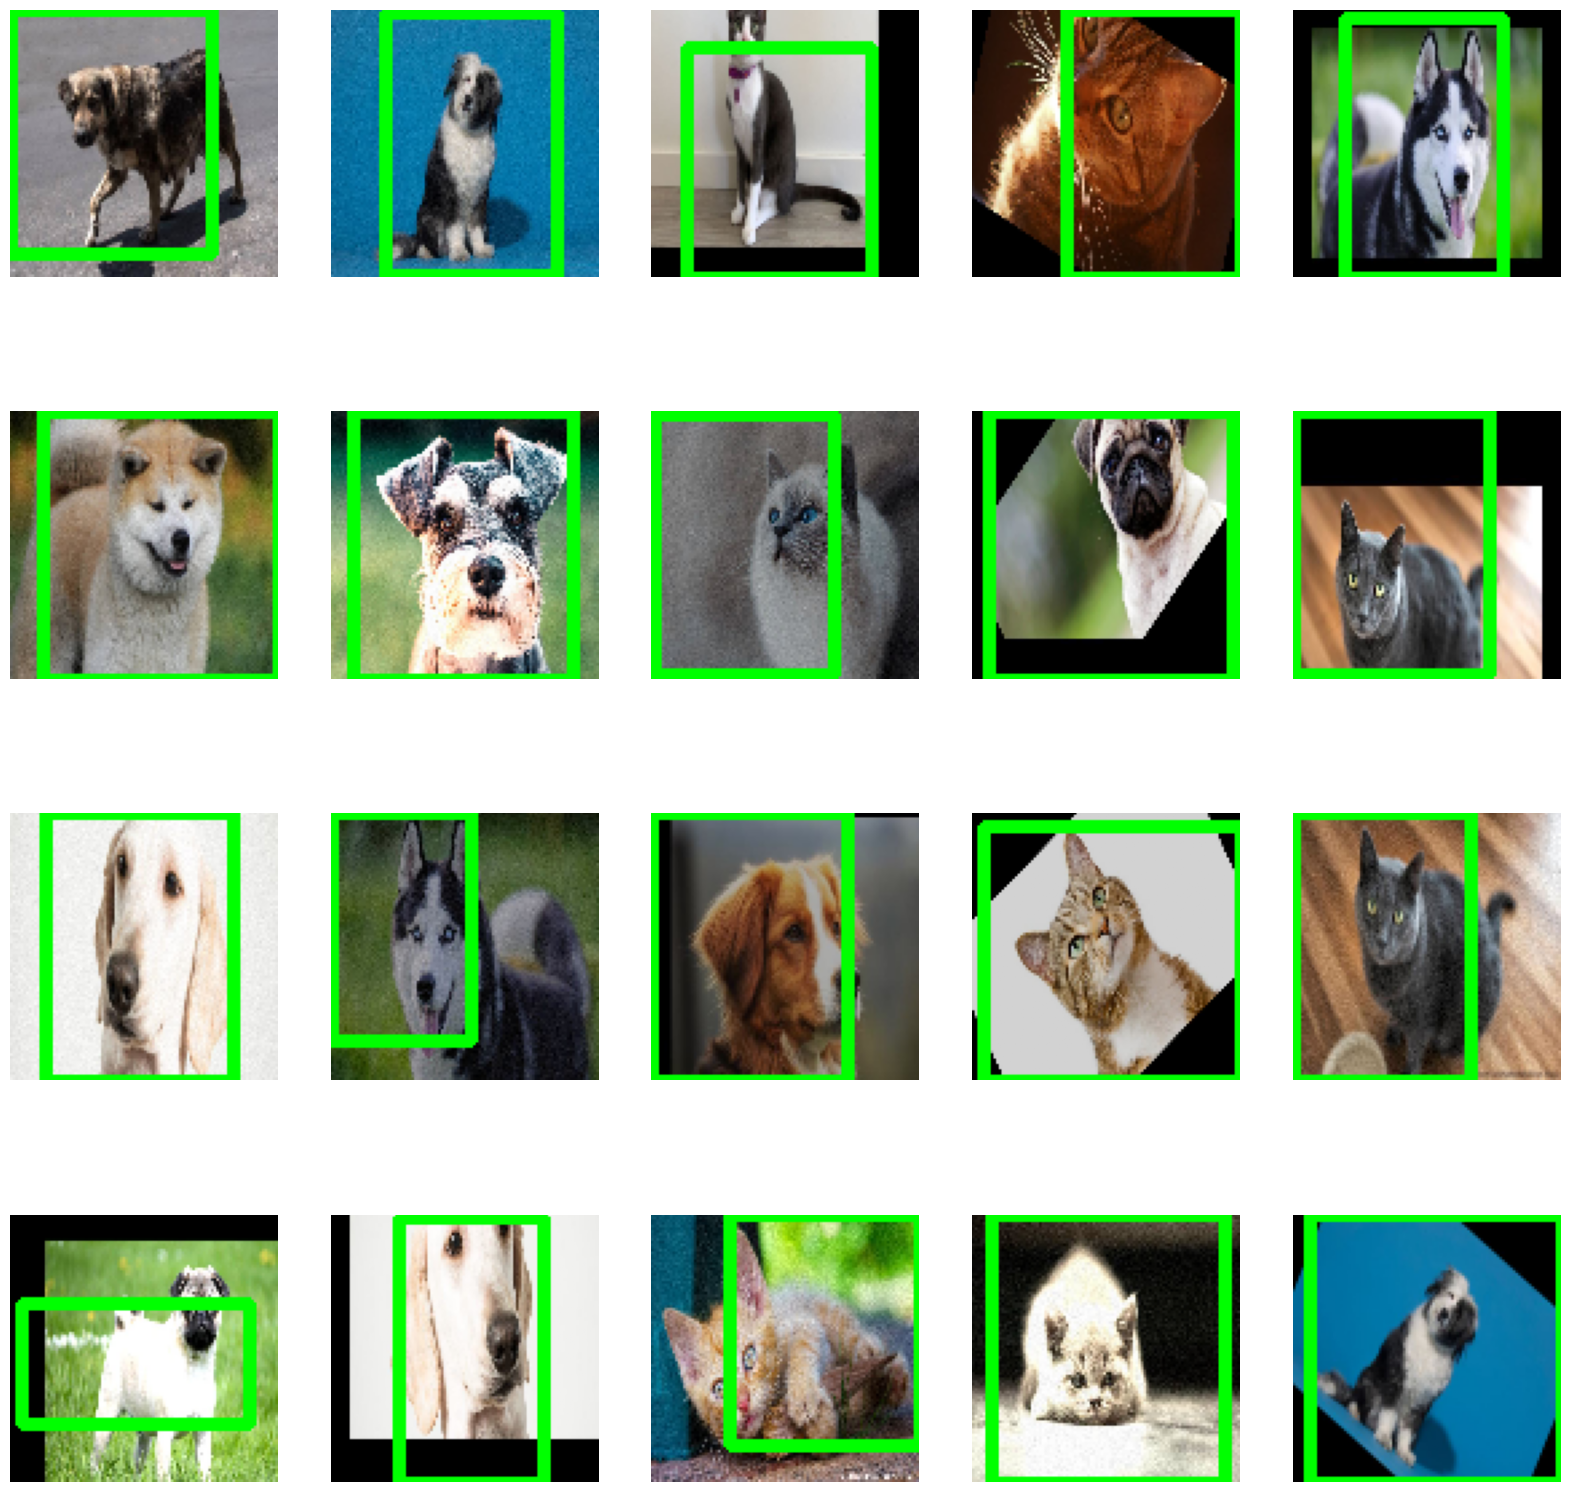

In [18]:
# Crear una figura de Matplotlib
plt.figure(figsize=(20,20));

# Generar una muestra aleatoria de imágenes cada vez que se ejecuta la celda
random_range = random.sample(range(1, len(img_list)), 20)
image_size=100
for iteration, i in enumerate(random_range, 1):

    # Cuadro delimitador de cada imagen
    a1, b1, a2, b2 = boxes[i];

    # Escalando los valores del cuadro delimitador para que coincidan con el tamaño de la imagen
    x1 = a1 * image_size
    x2 = a2 * image_size
    y1 = b1 * image_size
    y2 = b2 * image_size

    # La imagen a visualizar
    image = img_list[i]

    # Dibujar cuadros delimitadores en la imagen
    cv2.rectangle(image, (int(x1),int(y1)),
          (int(x2),int(y2)),
                  (0,255,0),
                  3);
    
    # Recorte los valores a 0-1 y dibuje la muestra de imágenes
    image = np.clip(img_list[i], 0, 1)
    plt.subplot(4, 5, iteration);
    plt.imshow(image);
    plt.axis('off');

In [19]:
# Dividir los datos de imágenes, etiquetas y sus anotaciones
train_images, val_images, train_labels, \
val_labels, train_boxes, val_boxes = train_test_split( np.array(img_list), 
                np.array(onehot_labels), np.array(boxes), test_size = 0.1, 
                random_state = 43)

print('Total Training Images: {}, Total Validation Images: {}'.format(
    len(train_images), len(val_images) ))

Total Training Images: 180, Total Validation Images: 20


In [20]:
# Cargue el modelo NasNetMobile, asegúrese de excluir la parte superior para el aprendizaje de transferencia
N_mobile = tf.keras.applications.NASNetMobile( input_tensor = Input(
    shape=(image_size, image_size, 3)), 
    include_top=False, 
    weights='imagenet')

In [32]:
# Vamos a crear una función que construya nuestro modelo
def create_model(no_of_classes):

    # Congelar todo el modelo
    N_mobile.trainable = False
    
    # Comience tomando los mapas de características de salida de NASNETMobile
    base_model_output = N_mobile.output
    
    # Convertir a un vector unidimensional mediante Global Average Pooling.

     # También podríamos usar Flatten()(x) pero GAP es más efectivo, reduce
     # Sobreajuste de parámetros y controles.
    flattened_output = GlobalAveragePooling2D()(base_model_output)

    # Cree su Cabezal de clasificación, la capa final contiene 
    # Unidades de salida = no. clases
    class_prediction = Dense(256, activation="relu")(flattened_output)
    class_prediction = Dense(128, activation="relu")(class_prediction )
    class_prediction = Dropout(0.2)(class_prediction)
    class_prediction = Dense(64, activation="relu")(class_prediction)
    class_prediction = Dropout(0.2)(class_prediction )
    class_prediction = Dense(32, activation="relu")(class_prediction)
    class_prediction = Dense(no_of_classes, activation='softmax',
                             name="class_output")(class_prediction)


    # Crear nuestro encabezado de localización, la capa final contiene 4 nodos para x1, y1, x2, y2
    # Respectivamente.
    box_output = Dense(256, activation="relu")(flattened_output)
    box_output = Dense(128, activation="relu")(box_output)
    box_output = Dropout(0.2)(box_output )

    box_output = Dense(64, activation="relu")(box_output)
    box_output = Dropout(0.2)(box_output )

    box_output = Dense(32, activation="relu")(box_output)
    box_predictions = Dense(4, activation='sigmoid',
                            name= "box_output")(box_output)

    # Ahora combina las dos cabezas
    model = Model(inputs=N_mobile.input, outputs= [box_predictions, 
                                                   class_prediction])

    return model

# Crea el modelo para 2 clases, perro,gato
model = create_model(2); print("Model Created")

Model Created


In [33]:
#estructura del modelo
plot_model(model, to_file='model_plot.png', show_shapes=True, 
           show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [34]:
# Aquí para cada cabeza definiremos una pérdida diferente, la definiremos
# Como un diccionario.

# Para la clasificacion tendremos crossentropia cateogrica
# Para las cajas delimitadoras tendremos el error cuadrático medio
losses = { 
    "box_output": "mean_squared_error",
    "class_output": "categorical_crossentropy"
    }

# Aquí puedes dar más o menos peso a cada pérdida.

# Si cree que la detección es más difícil que la clasificación, entonces puede
# Intenta asignarle más peso
loss_weights = {
    "box_output": 1.0, 
    "class_output": 1.0
    }

# Establecer las métricas
# Para las etiquetas de clase queremos saber la Precisión
# Y para los cuadros delimitadores necesitamos saber el error cuadrático medio
metrics = {
    'class_output': 'accuracy', 
    'box_output':  'mse'
    }

# Usaremos la detención anticipada para detener el modelo si la pérdida total de valor no lo hace
# Disminuir en 0.001 en 40 épocas
stop = EarlyStopping(monitor = "val_loss", min_delta = 0.0001, patience = 40, 
                    restore_best_weights = True
                     )

# Cambie la tasa de aprendizaje según el número de épocas para impulsar el aprendizaje
reduce_lr = ReduceLROnPlateau(monitor = "val_loss", factor = 0.0002, 
                              patience = 30, min_lr = 1e-7, verbose = 1)

# Inicializar Optimizador
opt = SGD(learning_rate = 1e-3, momentum = 0.9)

# Compile el modelo con el optimizador de Adam
model.compile(optimizer = opt, loss = losses, loss_weights = loss_weights, 
    metrics = metrics)

In [35]:
train_images[0].shape

(100, 100, 3)

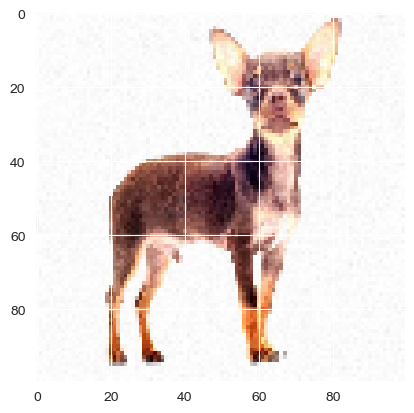

In [78]:
plt.imshow(train_images[3])

In [37]:
# Entrenar al modelo
history = model.fit(x = train_images, 
                    y= {
                        "box_output": train_boxes, 
                        "class_output": train_labels
                        }, 
                    validation_data=(
                        val_images, 
                        {
                          "box_output": val_boxes, 
                          "class_output": val_labels
                          }), batch_size = 32, epochs = 500, 
                    callbacks=[reduce_lr, stop])

Epoch 1/500
6/6 [==============================] - 13s 697ms/step - loss: 0.9373 - box_output_loss: 0.2263 - class_output_loss: 0.7111 - box_output_mse: 0.2263 - class_output_accuracy: 0.5444 - val_loss: 1.2859 - val_box_output_loss: 0.2298 - val_class_output_loss: 1.0560 - val_box_output_mse: 0.2298 - val_class_output_accuracy: 0.4000 - lr: 0.0010
Epoch 2/500
6/6 [==============================] - 1s 160ms/step - loss: 0.8716 - box_output_loss: 0.2125 - class_output_loss: 0.6590 - box_output_mse: 0.2125 - class_output_accuracy: 0.6056 - val_loss: 1.0531 - val_box_output_loss: 0.2131 - val_class_output_loss: 0.8400 - val_box_output_mse: 0.2131 - val_class_output_accuracy: 0.4500 - lr: 0.0010
Epoch 3/500
6/6 [==============================] - 1s 167ms/step - loss: 0.8342 - box_output_loss: 0.1974 - class_output_loss: 0.6368 - box_output_mse: 0.1974 - class_output_accuracy: 0.6056 - val_loss: 0.9085 - val_box_output_loss: 0.1936 - val_class_output_loss: 0.7149 - val_box_output_mse: 0.193

In [39]:
def plot(var1, var2, plot_name):
  # Obtenga las métricas de pérdida del modelo entrenado
  c1 = history.history[var1]
  c2 = history.history[var2]

  epochs = range(len(c1))
  
  # Graficar las métricas
  plt.plot(epochs, c1, 'b', label=var1)
  plt.plot(epochs, c2, 'r', label=var2)
  plt.title(str(plot_name))
  plt.legend()

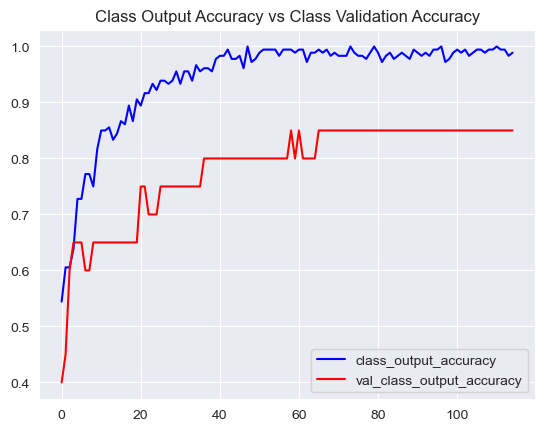

In [40]:
plot('class_output_accuracy','val_class_output_accuracy','Class Output Accuracy vs Class Validation Accuracy')

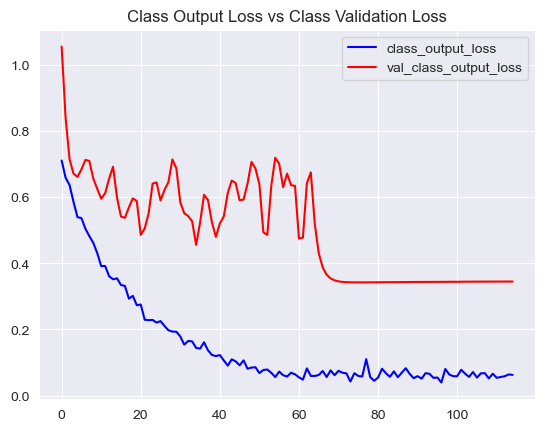

In [41]:
plot('class_output_loss','val_class_output_loss','Class Output Loss vs Class Validation Loss')

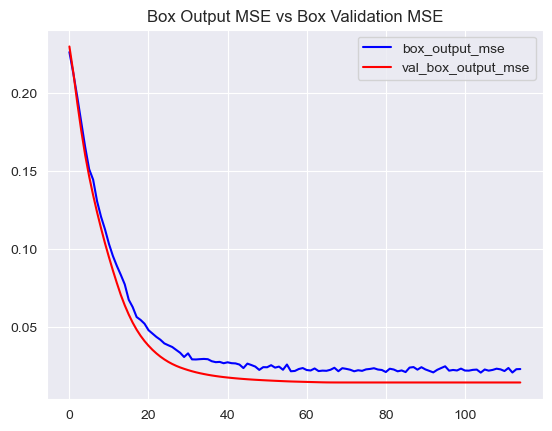

In [42]:
plot('box_output_mse','val_box_output_mse','Box Output MSE vs Box Validation MSE')

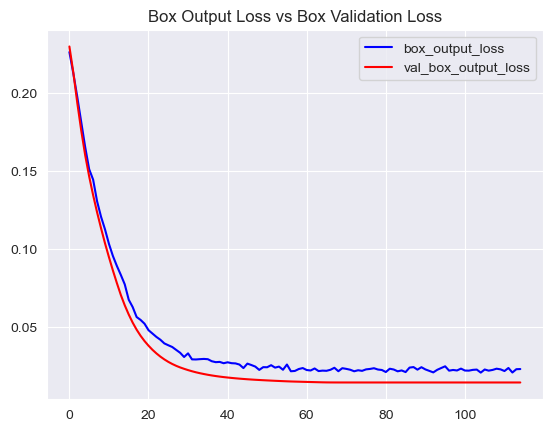

In [43]:
plot('box_output_loss','val_box_output_loss','Box Output Loss vs Box Validation Loss')

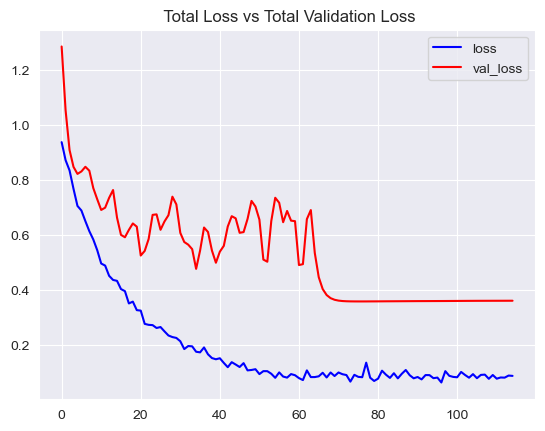

In [44]:
# Estas son las métricas más importantes para decirnos cómo le está yendo a nuestro modelo
plot('loss','val_loss',' Total Loss vs Total Validation Loss')

# 8. Después del entrenamiento, descargue algunas fotos nuevas de perros y gatos y vea qué tan bien se desempeña su modelo

In [87]:
# Ingrese los nombres de sus clases en esta lista
global label_names

# Debe ser igual a la lista de anotaciones que usamos para elegir los datos
label_names = sorted(['perros', 'gatos'])

In [88]:
# Usaremos esta función para hacer predicciones sobre imágenes.
def predict(image, returnimage = False,  scale = 0.9):
  
  # Antes de que podamos hacer una predicción, necesitamos preprocesar la imagen.
  processed_image = preprocess(image)

  # Ahora podemos usar nuestro modelo para la predicción
  results = model.predict(processed_image)

  # Ahora tenemos que posprocesar estos resultados.
  # Después del posprocesamiento, podemos usar fácilmente nuestros resultados
  label, (x1, y1, x2, y2), confidence = postprocess(image, results)

  # Ahora anota la imagen.
  cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 100), 2)
  cv2.putText(
      image, 
      '{}'.format(label, confidence), 
      (x1, y2 + int(35 * scale)), 
      cv2.FONT_HERSHEY_COMPLEX, scale,
      (200, 55, 100),
      2
      )

  # Mostrar la imagen con matplotlib
  plt.figure(figsize=(10,10))
  plt.imshow(image[:,:,::-1])

In [89]:
# Esta función preprocesará las imágenes.
def preprocess(img, image_size = 100):
  
    image = cv2.resize(img, (image_size, image_size))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image.astype("float") / 255.0 

    # Expanda las dimensiones como predice la imagen esperada en lotes
    image = np.expand_dims(image, axis=0) 
    return image

In [90]:
def postprocess(image, results):

    # Dividir los resultados en probabilidades de clase y coordenadas de caja
    bounding_box, class_probs = results

    # Primero obtengamos la etiqueta de clase

    # El índice de clase con la confianza más alta es nuestra clase objetivo
    class_index = np.argmax(class_probs)
  
    # Utilice este índice para obtener el nombre de la clase.
    class_label = label_names[class_index]

    # Ahora también puede extraer el cuadro delimitador.

    # Obtener la altura y el ancho de la imagen real
    h, w = image.shape[:2]

    # Extraer las coordenadas
    x1, y1, x2, y2 = bounding_box[0]

    # Convierta las coordenadas de relativas (es decir, 0-1) a valores reales
    x1 = int(w * x1)
    x2 = int(w * x2)
    y1 = int(h * y1)
    y2 = int(h * y2)

    # devolver la etiqueta y las coordenadas
    return class_label, (x1,y1,x2,y2),class_probs

1/1 [==============================] - 0s 26ms/step


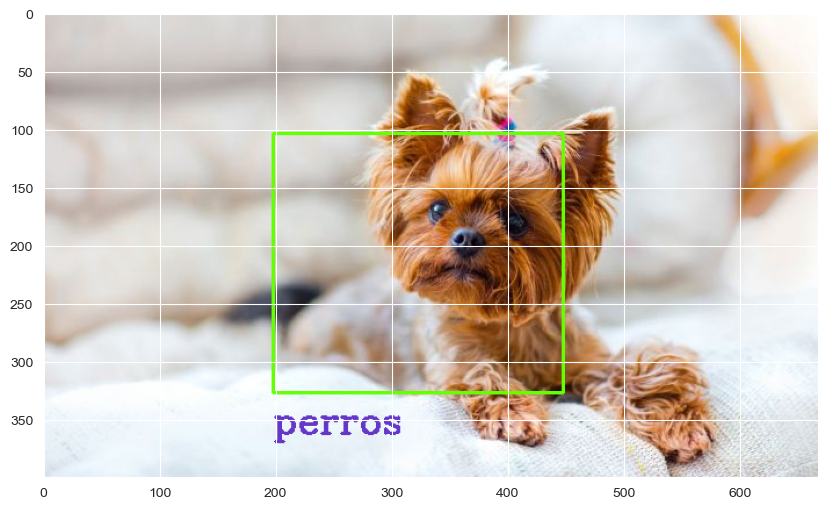

In [100]:
image = cv2.imread('dog6.jpg')
predict(image, scale = 1)

1/1 [==============================] - 0s 29ms/step


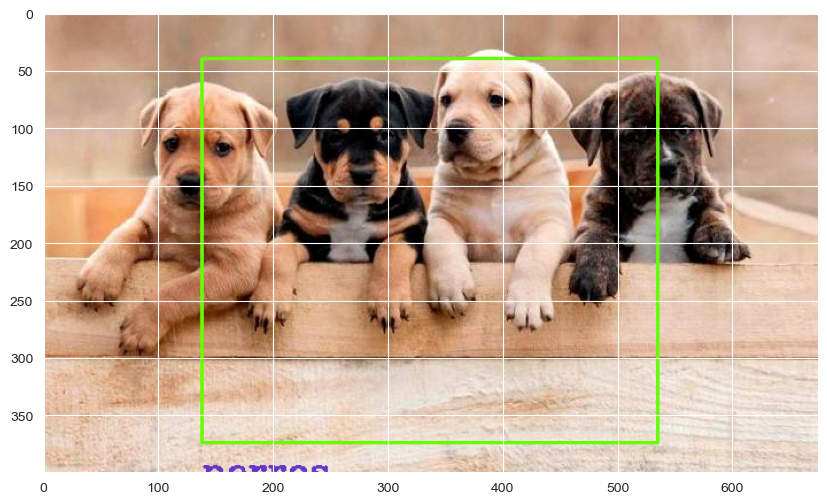

In [92]:
image = cv2.imread('dog10.jpg')
predict(image, scale = 1)

1/1 [==============================] - 0s 30ms/step


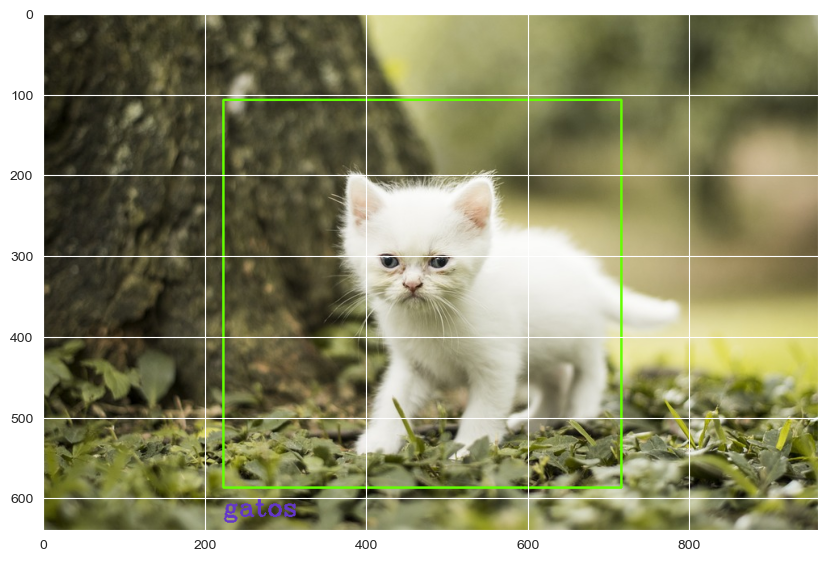

In [101]:
image = cv2.imread('cat4.jpg')
predict(image, scale = 1)

1/1 [==============================] - 0s 29ms/step


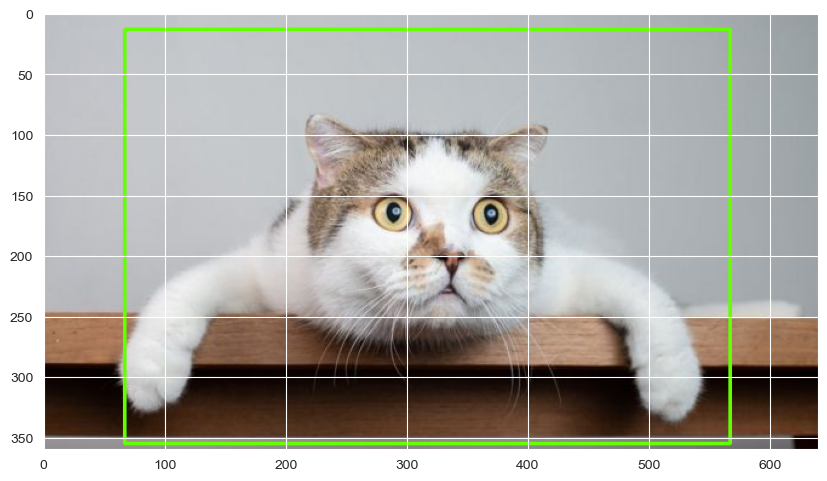

In [110]:
image = cv2.imread('cat7.jpg')
predict(image, scale = 1)